# If you want to access the version you have already modified, click "Edit"
# If you want to access the original sample code, click "...", then click "Copy & Edit Notebook"

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.0.1+cu117
True


In [2]:
import cv2

In [3]:
torch.cuda.set_device(2)

In [4]:
_exp_name = "pre_semi_spin"
number_class=101
a_style='all spins'
a_type_1='all spins'
a_type_2='a+0.94_shi'

In [5]:
# Import necessary packages.
import numpy as np
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [6]:
myseed = 11021  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## **Transforms**
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [7]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((224, 224)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])


## **Datasets**
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [8]:

import os
import re

#INTER_LINEAR – a bilinear interpolation (used by default)

def RHdataset(root_dir):
    Rh_data = []
    IMG_SIZE = 224
    labels = []
    
    for filename in os.listdir(root_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            # 組合完整的檔案路徑
            file_path = os.path.join(root_dir, filename)

            # 讀取照片
            img = cv2.imread(file_path)

            # 確保成功讀取照片
            if img is not None:
                # 將照片 resize 到指定的尺寸
                resized_img = cv2.resize(img, (224, 224),interpolation=cv2.INTER_LINEAR)
                #resized_img=resized_img/255
                #resized_img[0] = (resized_img[0]-0.485)/0.229
                #resized_img[1] = (resized_img[1]-0.456)/0.224
                #resized_img[2] = (resized_img[2]-0.406)/0.225
                
                # 將 resize 後的照片加入列表
                Rh_data.append(resized_img)
            else:
                print(f"無法讀取照片: {file_path}")
                
    for filename in os.listdir(root_dir):
        # 使用正則表達式匹配檔案名稱中的數字部分，並轉換為浮點數
        match = re.search(r'a([\d.]+)_', filename)
        if match:
            label = float(match.group(1))
            label=label*100
            labels.append(label)

    
    return Rh_data, labels


In [9]:
'''
import numpy as np

# 定义最小值和最大值
min_value = 1
max_value = 160

# 原始标签数据
labels = [1, 10, 20, 40, 80,160]

# 标签标准化
normalized_labels = [(y - min_value) / (max_value - min_value) for y in labels]

# 输出标准化后的标签数据
print(normalized_labels[0])
'''

'\nimport numpy as np\n\n# 定义最小值和最大值\nmin_value = 1\nmax_value = 160\n\n# 原始标签数据\nlabels = [1, 10, 20, 40, 80,160]\n\n# 标签标准化\nnormalized_labels = [(y - min_value) / (max_value - min_value) for y in labels]\n\n# 输出标准化后的标签数据\nprint(normalized_labels[0])\n'

In [10]:

u94_Rh1_data,u94_Rh1_label = RHdataset(root_dir="semi_anlayic/raif_img/")
print('all are ok')
'''
u94_Rh160_data,u94_Rh160_label=RHdataset(root_dir=f"SANE_{a_type_1}/Rh160",label_num=16)
'''

all are ok


'\nu94_Rh160_data,u94_Rh160_label=RHdataset(root_dir=f"SANE_{a_type_1}/Rh160",label_num=16)\n'

In [11]:
'''
d94_Rh1_data,d94_Rh1_label = RHdataset(root_dir=f"SANE_{a_type_2}/Rh1",label_num=17)
d94_Rh10_data,d94_Rh10_label=RHdataset(root_dir=f"SANE_{a_type_2}/Rh10",label_num=18)
'''

'\nd94_Rh1_data,d94_Rh1_label = RHdataset(root_dir=f"SANE_{a_type_2}/Rh1",label_num=17)\nd94_Rh10_data,d94_Rh10_label=RHdataset(root_dir=f"SANE_{a_type_2}/Rh10",label_num=18)\n'

In [12]:
'''
d94_Rh20_data,d94_Rh20_label=RHdataset(root_dir=f"SANE_{a_type_2}/Rh20",label_num=19)
d94_Rh40_data,d94_Rh40_label=RHdataset(root_dir=f"SANE_{a_type_2}/Rh40",label_num=21)
'''

'\nd94_Rh20_data,d94_Rh20_label=RHdataset(root_dir=f"SANE_{a_type_2}/Rh20",label_num=19)\nd94_Rh40_data,d94_Rh40_label=RHdataset(root_dir=f"SANE_{a_type_2}/Rh40",label_num=21)\n'

In [13]:
'''
d94_Rh80_data,d94_Rh80_label=RHdataset(root_dir=f"SANE_{a_type_2}/Rh80",label_num=25)
d94_Rh160_data,d94_Rh160_label=RHdataset(root_dir=f"SANE_{a_type_2}/Rh160",label_num=33)
'''

'\nd94_Rh80_data,d94_Rh80_label=RHdataset(root_dir=f"SANE_{a_type_2}/Rh80",label_num=25)\nd94_Rh160_data,d94_Rh160_label=RHdataset(root_dir=f"SANE_{a_type_2}/Rh160",label_num=33)\n'

In [14]:
print(len(u94_Rh1_data))

2833


In [15]:
print(min(u94_Rh1_label))

0.0


In [16]:
batch_size=16

In [17]:
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
# torch.nn.MaxPool2d(kernel_size, stride, padding)
# input 維度 [128,128,3]

In [18]:
import torchvision.models as models
# 載入預先訓練的 ResNet-18 模型
device = "cuda" if torch.cuda.is_available() else "cpu"  # "cuda" only when GPUs are available.
model = models.resnet18(pretrained=True)

# 將全連接層（分類層）修改為輸出 10 類的層
model.fc = nn.Linear(model.fc.in_features, number_class)

model = model.to(device)
# 定義 MSE loss
criterion = nn.MSELoss()

#weight_decay=1e-7
# 定義優化器
optimizer = torch.optim.Adam(model.parameters(), lr=7e-4,weight_decay=5e-6)

/home/DomCheng/miniconda3/envs/mas/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/DomCheng/miniconda3/envs/mas/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
from torchsummary import summary
device = "cuda" if torch.cuda.is_available() else "cpu"  # "cuda" only when GPUs are available.
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [20]:
'''
train_data=np.array(u94_Rh1_data)
label=np.array(u94_Rh1_label)
#d94_Rh1_data,d94_Rh10_data,d94_Rh20_data,d94_Rh40_data,d94_Rh80_data,d94_Rh160_data
#d94_Rh1_label,d94_Rh10_label,d94_Rh20_label,d94_Rh40_label,d94_Rh80_label,d94_Rh160_label
data_targets=[u94_Rh10_data,u94_Rh20_data,u94_Rh40_data,u94_Rh80_data,u94_Rh160_data
             ]
data_labels=[u94_Rh10_label,u94_Rh20_label,u94_Rh40_label,u94_Rh80_label,u94_Rh160_label
            ]
for i in data_targets:
    gg=np.array(i)
    train_data=np.append(train_data,gg,axis=0)

for i in data_labels:
    jj=np.array(i)
    label=np.append(label,jj)
'''

'\ntrain_data=np.array(u94_Rh1_data)\nlabel=np.array(u94_Rh1_label)\n#d94_Rh1_data,d94_Rh10_data,d94_Rh20_data,d94_Rh40_data,d94_Rh80_data,d94_Rh160_data\n#d94_Rh1_label,d94_Rh10_label,d94_Rh20_label,d94_Rh40_label,d94_Rh80_label,d94_Rh160_label\ndata_targets=[u94_Rh10_data,u94_Rh20_data,u94_Rh40_data,u94_Rh80_data,u94_Rh160_data\n             ]\ndata_labels=[u94_Rh10_label,u94_Rh20_label,u94_Rh40_label,u94_Rh80_label,u94_Rh160_label\n            ]\nfor i in data_targets:\n    gg=np.array(i)\n    train_data=np.append(train_data,gg,axis=0)\n\nfor i in data_labels:\n    jj=np.array(i)\n    label=np.append(label,jj)\n'

In [21]:
train_data=np.array(u94_Rh1_data)
label=np.array(u94_Rh1_label)

In [22]:
class RhDataset(Dataset):
    def __init__(self):
        self.x=train_data
        self.y=label

    def __getitem__(self, idx):
        
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

In [23]:
batch_size=32
train_set = RhDataset()

In [24]:
train_data_point, label_0 = train_set[101]
print(label_0)

17.0


In [25]:
print(len(train_data))
n_total = len(train_data)
n_train = int(0.6 * n_total)
n_valid = int(0.2* n_total)
n_test = n_total - n_train -n_valid
train_dataset,valid_dataset, test_dataset = torch.utils.data.random_split(train_set, [n_train,n_valid, n_test])


2833


In [26]:
tt,tl=train_dataset[0]
print(len(train_dataset))

1699


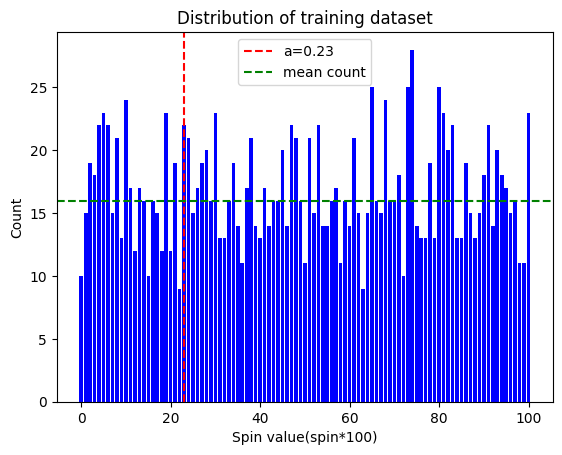

In [27]:
N_label=[]
for i in range(len(train_dataset)):
    tt,tl=train_dataset[i]
    N_label.append(tl)
    
import matplotlib.pyplot as plt


# 計算各數字的數量
counts = {num: N_label.count(num) for num in set(N_label)}

# 繪製直方圖
plt.bar(counts.keys(), counts.values(), color='blue')

# 在 x=5 的地方畫垂直線
plt.axvline(x=23.0, color='red', linestyle='--', label='a=0.23')

# 在 y=3 的地方畫水平線
plt.axhline(y=16, color='green', linestyle='--', label='mean count')

# 加上標籤和標題
plt.xlabel('Spin value(spin*100)')
plt.ylabel('Count')
plt.title('Distribution of training dataset')
plt.legend()

# 顯示圖形
plt.show()


In [28]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True,num_workers=0, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True,num_workers=0, pin_memory=True)

In [29]:
len(train_dataset)

1699

In [30]:
#1-160把1當成0，每10一分類，就有17類

n_epochs=500

patience = 40 
stale = 0
best_acc = 0

tra_loss=[]
val_loss=[]


for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    for images, labels in tqdm(train_loader):
        # 正向傳播
        images= images.permute(0, 3, 1, 2)
        images, labels = images.to(device), labels.to(device)
        labels=labels.long()
        images=images.float()
        outputs = model(images)
        loss = criterion(outputs, torch.nn.functional.one_hot(labels, number_class).float())  # 使用 one-hot 編碼

        # 反向傳播和優化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    
    tra_loss.append(train_loss)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    for images, labels in tqdm(valid_loader):
        # 正向傳播
        images= images.permute(0, 3, 1, 2)
        images=images.float()
        images, labels = images.to(device), labels.to(device)
        labels=labels.long()
        with torch.no_grad():
            outputs = model(images).to(device)
        loss = criterion(outputs, torch.nn.functional.one_hot(labels, number_class).float())  # 使用 one-hot 編碼

        
        acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    
    val_loss.append(valid_loss)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_{myseed}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break
print('訓練完成')

  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 001/500 ] loss = 0.02408, acc = 0.01505


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 001/500 ] loss = 0.01066, acc = 0.00694
Best model found at epoch 0, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 002/500 ] loss = 0.01061, acc = 0.01910


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 002/500 ] loss = 0.01068, acc = 0.06250
Best model found at epoch 1, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 003/500 ] loss = 0.01048, acc = 0.04225


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 003/500 ] loss = 0.01061, acc = 0.03030


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 004/500 ] loss = 0.01040, acc = 0.07002


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 004/500 ] loss = 0.01109, acc = 0.01562


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 005/500 ] loss = 0.01025, acc = 0.09954


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 005/500 ] loss = 0.01159, acc = 0.00694


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 006/500 ] loss = 0.01018, acc = 0.13310


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 006/500 ] loss = 0.01078, acc = 0.02083


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 007/500 ] loss = 0.00995, acc = 0.18673


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 007/500 ] loss = 0.01161, acc = 0.07544
Best model found at epoch 6, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 008/500 ] loss = 0.00982, acc = 0.24923


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 008/500 ] loss = 0.01090, acc = 0.12579
Best model found at epoch 7, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 009/500 ] loss = 0.00924, acc = 0.31481


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 009/500 ] loss = 0.01063, acc = 0.13952
Best model found at epoch 8, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 010/500 ] loss = 0.00883, acc = 0.38426


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 010/500 ] loss = 0.01062, acc = 0.13778


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 011/500 ] loss = 0.00837, acc = 0.47473


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 011/500 ] loss = 0.00945, acc = 0.35717
Best model found at epoch 10, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 012/500 ] loss = 0.00790, acc = 0.51871


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 012/500 ] loss = 0.00964, acc = 0.32150


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 013/500 ] loss = 0.00737, acc = 0.56173


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 013/500 ] loss = 0.01043, acc = 0.28930


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 014/500 ] loss = 0.00712, acc = 0.59394


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 014/500 ] loss = 0.00846, acc = 0.39789
Best model found at epoch 13, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 015/500 ] loss = 0.00675, acc = 0.63445


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 015/500 ] loss = 0.00802, acc = 0.55035
Best model found at epoch 14, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 016/500 ] loss = 0.00636, acc = 0.66493


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 016/500 ] loss = 0.00794, acc = 0.59470
Best model found at epoch 15, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 017/500 ] loss = 0.00610, acc = 0.67728


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 017/500 ] loss = 0.00719, acc = 0.56929


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 018/500 ] loss = 0.00580, acc = 0.70370


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 018/500 ] loss = 0.00721, acc = 0.59691
Best model found at epoch 17, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 019/500 ] loss = 0.00560, acc = 0.72550


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 019/500 ] loss = 0.00659, acc = 0.64205
Best model found at epoch 18, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 020/500 ] loss = 0.00514, acc = 0.75135


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 020/500 ] loss = 0.00749, acc = 0.61948


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 021/500 ] loss = 0.00540, acc = 0.72936


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 021/500 ] loss = 0.00595, acc = 0.67140
Best model found at epoch 20, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 022/500 ] loss = 0.00500, acc = 0.75135


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 022/500 ] loss = 0.00637, acc = 0.65609


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 023/500 ] loss = 0.00486, acc = 0.76640


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 023/500 ] loss = 0.00574, acc = 0.70565
Best model found at epoch 22, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 024/500 ] loss = 0.00473, acc = 0.77180


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 024/500 ] loss = 0.00581, acc = 0.68655


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 025/500 ] loss = 0.00471, acc = 0.75579


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 025/500 ] loss = 0.00594, acc = 0.66383


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 026/500 ] loss = 0.00452, acc = 0.78762


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 026/500 ] loss = 0.00573, acc = 0.70533


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 027/500 ] loss = 0.00439, acc = 0.78800


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 027/500 ] loss = 0.00630, acc = 0.64283


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 028/500 ] loss = 0.00450, acc = 0.77585


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 028/500 ] loss = 0.00632, acc = 0.65767


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 029/500 ] loss = 0.00432, acc = 0.79938


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 029/500 ] loss = 0.00525, acc = 0.69492


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 030/500 ] loss = 0.00404, acc = 0.81481


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 030/500 ] loss = 0.00875, acc = 0.64220


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 031/500 ] loss = 0.00392, acc = 0.83970


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 031/500 ] loss = 0.00541, acc = 0.71670
Best model found at epoch 30, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 032/500 ] loss = 0.00376, acc = 0.82812


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 032/500 ] loss = 0.00539, acc = 0.72427
Best model found at epoch 31, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 033/500 ] loss = 0.00379, acc = 0.82639


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 033/500 ] loss = 0.00540, acc = 0.71496


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 034/500 ] loss = 0.00367, acc = 0.84221


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 034/500 ] loss = 0.00609, acc = 0.64205


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 035/500 ] loss = 0.00398, acc = 0.81520


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 035/500 ] loss = 0.00622, acc = 0.71828


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 036/500 ] loss = 0.00423, acc = 0.80883


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 036/500 ] loss = 0.00546, acc = 0.70249


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 037/500 ] loss = 0.00392, acc = 0.83758


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 037/500 ] loss = 0.00715, acc = 0.65420


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 038/500 ] loss = 0.00383, acc = 0.82890


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 038/500 ] loss = 0.00471, acc = 0.75284
Best model found at epoch 37, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 039/500 ] loss = 0.00315, acc = 0.87404


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 039/500 ] loss = 0.00494, acc = 0.75568
Best model found at epoch 38, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 040/500 ] loss = 0.00365, acc = 0.84259


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 040/500 ] loss = 0.00521, acc = 0.69586


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 041/500 ] loss = 0.00321, acc = 0.86265


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 041/500 ] loss = 0.00504, acc = 0.69760


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 042/500 ] loss = 0.00320, acc = 0.86478


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 042/500 ] loss = 0.00501, acc = 0.71386


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 043/500 ] loss = 0.00282, acc = 0.88715


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 043/500 ] loss = 0.00467, acc = 0.73737


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 044/500 ] loss = 0.00259, acc = 0.90336


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 044/500 ] loss = 0.00425, acc = 0.76689
Best model found at epoch 43, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 045/500 ] loss = 0.00230, acc = 0.93113


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 045/500 ] loss = 0.00431, acc = 0.78788
Best model found at epoch 44, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 046/500 ] loss = 0.00231, acc = 0.92419


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 046/500 ] loss = 0.00450, acc = 0.78425


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 047/500 ] loss = 0.00235, acc = 0.93403


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 047/500 ] loss = 0.00508, acc = 0.74416


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 048/500 ] loss = 0.00409, acc = 0.82195


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 048/500 ] loss = 0.00579, acc = 0.66367


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 049/500 ] loss = 0.00321, acc = 0.88619


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 049/500 ] loss = 0.00530, acc = 0.72885


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 050/500 ] loss = 0.00398, acc = 0.83526


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 050/500 ] loss = 0.00541, acc = 0.69492


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 051/500 ] loss = 0.00283, acc = 0.90336


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 051/500 ] loss = 0.00497, acc = 0.73974


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 052/500 ] loss = 0.00230, acc = 0.93287


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 052/500 ] loss = 0.00415, acc = 0.76342


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 053/500 ] loss = 0.00197, acc = 0.94232


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 053/500 ] loss = 0.00497, acc = 0.75126


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 054/500 ] loss = 0.00257, acc = 0.92361


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 054/500 ] loss = 0.00422, acc = 0.78583


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 055/500 ] loss = 0.00184, acc = 0.95023


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 055/500 ] loss = 0.00604, acc = 0.73737


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 056/500 ] loss = 0.00181, acc = 0.95448


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 056/500 ] loss = 0.00443, acc = 0.75568


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 057/500 ] loss = 0.00155, acc = 0.96817


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 057/500 ] loss = 0.00459, acc = 0.78520


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 058/500 ] loss = 0.00154, acc = 0.97454


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 058/500 ] loss = 0.00375, acc = 0.77983


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 059/500 ] loss = 0.00140, acc = 0.97801


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 059/500 ] loss = 0.00428, acc = 0.77367


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 060/500 ] loss = 0.00128, acc = 0.98167


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 060/500 ] loss = 0.00401, acc = 0.76594


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 061/500 ] loss = 0.00172, acc = 0.95312


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 061/500 ] loss = 0.00396, acc = 0.79719
Best model found at epoch 60, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 062/500 ] loss = 0.00160, acc = 0.96991


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 062/500 ] loss = 0.00381, acc = 0.78677


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 063/500 ] loss = 0.00136, acc = 0.97627


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 063/500 ] loss = 0.00432, acc = 0.78141


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 064/500 ] loss = 0.00174, acc = 0.95563


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 064/500 ] loss = 0.00542, acc = 0.71654


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 065/500 ] loss = 0.00186, acc = 0.95428


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 065/500 ] loss = 0.00502, acc = 0.73122


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 066/500 ] loss = 0.00132, acc = 0.98438


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 066/500 ] loss = 0.00423, acc = 0.76278


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 067/500 ] loss = 0.00107, acc = 0.98843


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 067/500 ] loss = 0.00349, acc = 0.79198


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 068/500 ] loss = 0.00076, acc = 0.99363


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 068/500 ] loss = 0.00379, acc = 0.80161
Best model found at epoch 67, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 069/500 ] loss = 0.00074, acc = 0.99769


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 069/500 ] loss = 0.00371, acc = 0.80082


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 070/500 ] loss = 0.00079, acc = 0.99190


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 070/500 ] loss = 0.00368, acc = 0.78267


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 071/500 ] loss = 0.00105, acc = 0.98553


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 071/500 ] loss = 0.00364, acc = 0.79182


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 072/500 ] loss = 0.00159, acc = 0.96296


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 072/500 ] loss = 0.00469, acc = 0.74542


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 073/500 ] loss = 0.00164, acc = 0.95660


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 073/500 ] loss = 0.00443, acc = 0.75710


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 074/500 ] loss = 0.00155, acc = 0.96875


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 074/500 ] loss = 0.00443, acc = 0.74700


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 075/500 ] loss = 0.00157, acc = 0.95853


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 075/500 ] loss = 0.00455, acc = 0.75726


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 076/500 ] loss = 0.00193, acc = 0.94560


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 076/500 ] loss = 0.00490, acc = 0.73043


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 077/500 ] loss = 0.00207, acc = 0.93596


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 077/500 ] loss = 0.00429, acc = 0.76941


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 078/500 ] loss = 0.00190, acc = 0.94907


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 078/500 ] loss = 0.00502, acc = 0.71922


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 079/500 ] loss = 0.00128, acc = 0.97569


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 079/500 ] loss = 0.00435, acc = 0.75979


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 080/500 ] loss = 0.00086, acc = 0.99653


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 080/500 ] loss = 0.00381, acc = 0.77478


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 081/500 ] loss = 0.00065, acc = 0.99826


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 081/500 ] loss = 0.00363, acc = 0.79545


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 082/500 ] loss = 0.00055, acc = 0.99942


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 082/500 ] loss = 0.00404, acc = 0.79451


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 083/500 ] loss = 0.00287, acc = 0.88947


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 083/500 ] loss = 0.00527, acc = 0.68718


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 084/500 ] loss = 0.00198, acc = 0.94097


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 084/500 ] loss = 0.00468, acc = 0.74100


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 085/500 ] loss = 0.00098, acc = 0.99132


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 085/500 ] loss = 0.00398, acc = 0.76073


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 086/500 ] loss = 0.00077, acc = 0.99479


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 086/500 ] loss = 0.00370, acc = 0.77620


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 087/500 ] loss = 0.00061, acc = 0.99711


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 087/500 ] loss = 0.00383, acc = 0.77715


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 088/500 ] loss = 0.00055, acc = 0.99769


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 088/500 ] loss = 0.00334, acc = 0.79104


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 089/500 ] loss = 0.00049, acc = 0.99884


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 089/500 ] loss = 0.00321, acc = 0.78772


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 090/500 ] loss = 0.00051, acc = 1.00000


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 090/500 ] loss = 0.00335, acc = 0.79814


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 091/500 ] loss = 0.00049, acc = 0.99826


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 091/500 ] loss = 0.00347, acc = 0.77999


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 092/500 ] loss = 0.00053, acc = 0.99537


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 092/500 ] loss = 0.00337, acc = 0.78867


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 093/500 ] loss = 0.00061, acc = 0.99884


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 093/500 ] loss = 0.00332, acc = 0.80524
Best model found at epoch 92, saving model


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 094/500 ] loss = 0.00067, acc = 0.99190


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 094/500 ] loss = 0.00423, acc = 0.76783


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 095/500 ] loss = 0.00081, acc = 0.99074


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 095/500 ] loss = 0.00407, acc = 0.75205


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 096/500 ] loss = 0.00124, acc = 0.98148


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 096/500 ] loss = 0.00457, acc = 0.72001


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 097/500 ] loss = 0.00197, acc = 0.94329


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 097/500 ] loss = 0.00513, acc = 0.69492


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 098/500 ] loss = 0.00162, acc = 0.95795


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 098/500 ] loss = 0.00483, acc = 0.68640


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 099/500 ] loss = 0.00176, acc = 0.94965


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 099/500 ] loss = 0.00456, acc = 0.71070


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 100/500 ] loss = 0.00141, acc = 0.96373


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 100/500 ] loss = 0.00501, acc = 0.74321


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 101/500 ] loss = 0.00329, acc = 0.84452


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 101/500 ] loss = 0.00511, acc = 0.70628


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 102/500 ] loss = 0.00222, acc = 0.92361


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 102/500 ] loss = 0.00504, acc = 0.72475


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 103/500 ] loss = 0.00158, acc = 0.95660


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 103/500 ] loss = 0.00411, acc = 0.75363


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 104/500 ] loss = 0.00137, acc = 0.97049


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 104/500 ] loss = 0.00429, acc = 0.75032


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 105/500 ] loss = 0.00085, acc = 0.98669


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 105/500 ] loss = 0.00476, acc = 0.66809


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 106/500 ] loss = 0.00059, acc = 0.99306


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 106/500 ] loss = 0.00354, acc = 0.77036


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 107/500 ] loss = 0.00042, acc = 0.99711


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 107/500 ] loss = 0.00368, acc = 0.77036


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 108/500 ] loss = 0.00043, acc = 0.99595


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 108/500 ] loss = 0.00334, acc = 0.78251


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 109/500 ] loss = 0.00035, acc = 1.00000


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 109/500 ] loss = 0.00339, acc = 0.79545


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 110/500 ] loss = 0.00047, acc = 1.00000


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 110/500 ] loss = 0.00338, acc = 0.80003


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 111/500 ] loss = 0.00044, acc = 1.00000


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 111/500 ] loss = 0.00336, acc = 0.79467


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 112/500 ] loss = 0.00041, acc = 1.00000


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 112/500 ] loss = 0.00320, acc = 0.79624


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 113/500 ] loss = 0.00058, acc = 0.99653


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 113/500 ] loss = 0.00525, acc = 0.73753


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 114/500 ] loss = 0.00080, acc = 0.98843


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 114/500 ] loss = 0.00350, acc = 0.79798


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 115/500 ] loss = 0.00076, acc = 0.99363


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 115/500 ] loss = 0.00381, acc = 0.76941


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 116/500 ] loss = 0.00105, acc = 0.98322


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 116/500 ] loss = 0.00466, acc = 0.71133


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 117/500 ] loss = 0.00142, acc = 0.96759


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 117/500 ] loss = 0.00525, acc = 0.68466


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 118/500 ] loss = 0.00128, acc = 0.97049


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 118/500 ] loss = 0.00437, acc = 0.75994


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 119/500 ] loss = 0.00104, acc = 0.97917


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 119/500 ] loss = 0.00404, acc = 0.74590


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 120/500 ] loss = 0.00085, acc = 0.98669


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 120/500 ] loss = 0.00403, acc = 0.77115


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 121/500 ] loss = 0.00077, acc = 0.99074


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 121/500 ] loss = 0.00380, acc = 0.78362


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 122/500 ] loss = 0.00068, acc = 0.99248


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 122/500 ] loss = 0.00411, acc = 0.74448


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 123/500 ] loss = 0.00070, acc = 0.99074


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 123/500 ] loss = 0.00459, acc = 0.70802


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 124/500 ] loss = 0.00138, acc = 0.96065


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 124/500 ] loss = 0.00487, acc = 0.70818


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 125/500 ] loss = 0.00157, acc = 0.96296


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 125/500 ] loss = 0.00466, acc = 0.71985


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 126/500 ] loss = 0.00097, acc = 0.98438


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 126/500 ] loss = 0.00406, acc = 0.73627


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 127/500 ] loss = 0.00079, acc = 0.98167


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 127/500 ] loss = 0.00443, acc = 0.72554


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 128/500 ] loss = 0.00162, acc = 0.94155


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 128/500 ] loss = 0.00526, acc = 0.69776


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 129/500 ] loss = 0.00165, acc = 0.94444


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 129/500 ] loss = 0.00473, acc = 0.71922


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 130/500 ] loss = 0.00100, acc = 0.98264


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 130/500 ] loss = 0.00456, acc = 0.73485


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 131/500 ] loss = 0.00278, acc = 0.88600


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 131/500 ] loss = 0.00502, acc = 0.68908


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 132/500 ] loss = 0.00152, acc = 0.95775


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 132/500 ] loss = 0.00441, acc = 0.71938


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 133/500 ] loss = 0.00076, acc = 0.99306


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 133/500 ] loss = 0.00377, acc = 0.77289


  0%|          | 0/54 [00:00<?, ?it/s]

[ Train | 134/500 ] loss = 0.00046, acc = 0.99884


  0%|          | 0/18 [00:00<?, ?it/s]

[ Valid | 134/500 ] loss = 0.00362, acc = 0.77225
No improvment 40 consecutive epochs, early stopping
訓練完成


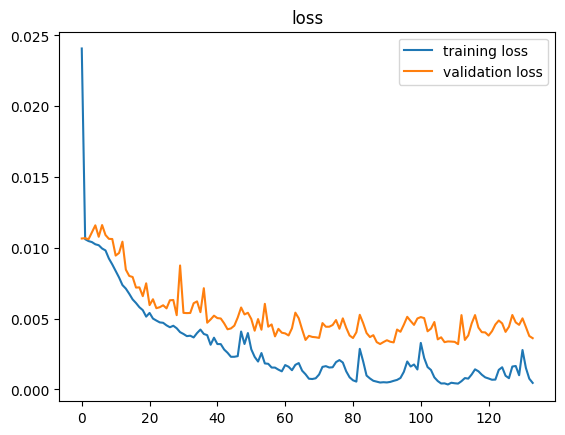

In [31]:
import matplotlib.pyplot as plt


plt.plot(tra_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
#plt.ylim(0,0.02)
plt.title('loss')
plt.legend()

In [32]:
import numpy as np

# 將 pp 和 aa 轉換成 numpy array
pp_array = np.array(tra_loss)
aa_array = np.array(val_loss)

# 儲存到文本檔案
np.savetxt('qq2.txt', np.column_stack((pp_array, aa_array)), delimiter=',', header='pp,aa', comments='')

print("Data has been saved to qq.txt.")


Data has been saved to qq.txt.


## Testing and generate prediction CSV

In [33]:

import seaborn as sns
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"  # "cuda" only when GPUs are available.

model = models.resnet18(pretrained=True)

# 將全連接層（分類層）修改為輸出 10 類的層
model.fc = nn.Linear(model.fc.in_features, 101)

model_best = model.to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_{myseed}_best.ckpt"))
model_best.eval()


total_y_true = []
total_predi = []

for p in tqdm(range(50)):
    
    for batch in test_loader:
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.float()
        imgs = imgs.permute(0, 3, 1, 2)
        #imgs = torch.unsqueeze(imgs, dim=0)  # 在第0维上增加一个维度
        
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            test_pred = model_best(imgs.to(device))
    total_y_true.append(labels.cpu())
    total_predi.append(test_pred.argmax(dim=-1).cpu())
    p=p+1


#llabels=np.array(['Rh1','Rh10','Rh20','Rh40','Rh80','Rh160'])   
#print(len(np.concatenate(total_y_true)))
#print(len(np.concatenate(total_predi)))


/home/DomCheng/miniconda3/envs/mas/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/DomCheng/miniconda3/envs/mas/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/50 [00:00<?, ?it/s]

In [34]:
#print(np.concatenate(total_y_true))

In [35]:
#print(np.concatenate(total_predi))

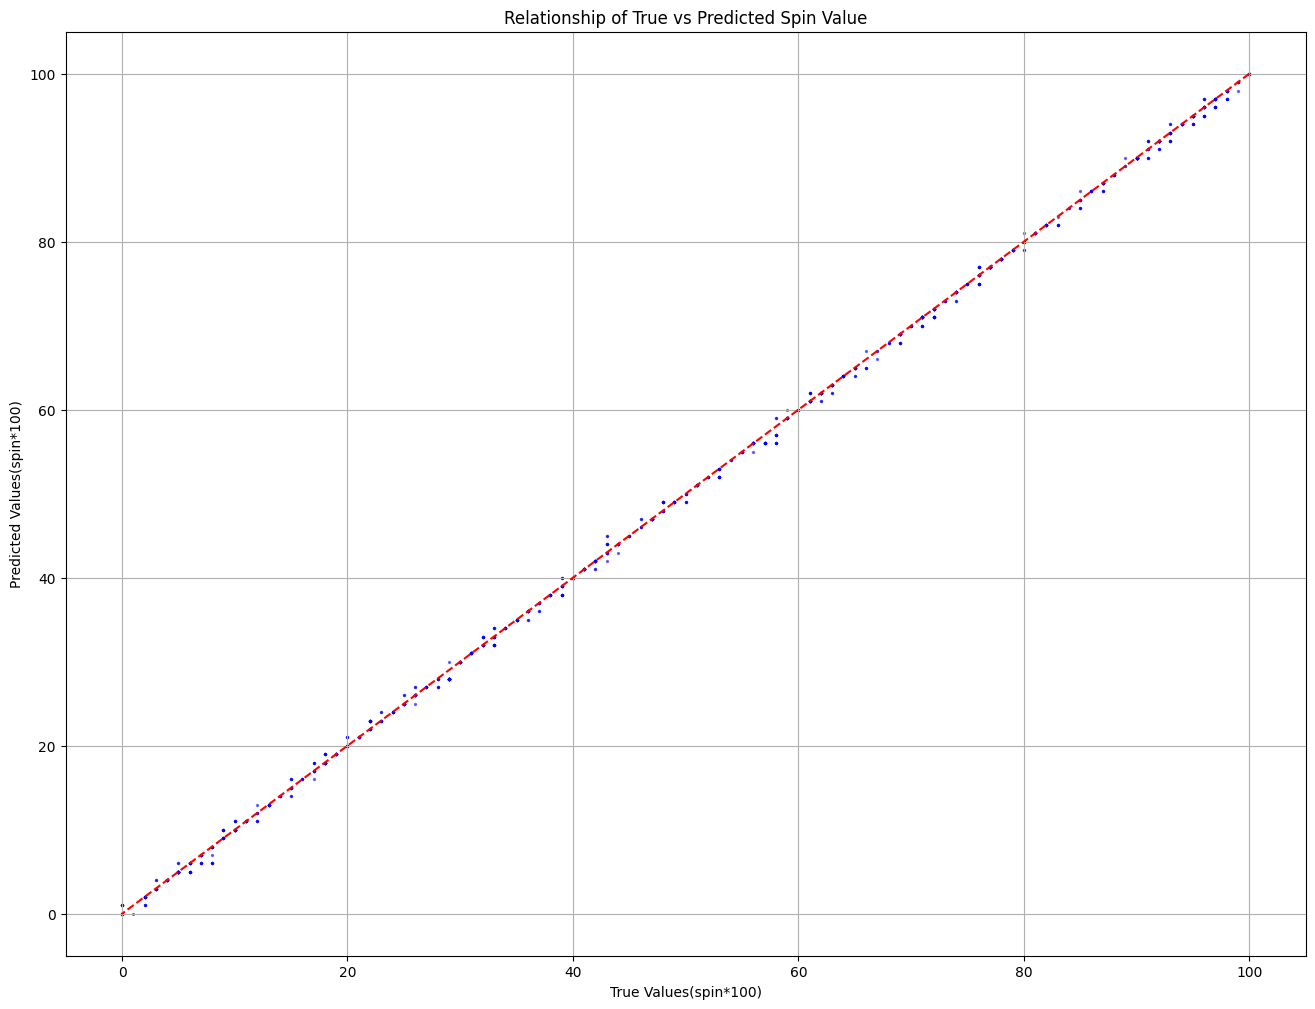

In [36]:
import matplotlib.pyplot as plt


yy_true=np.concatenate(total_y_true)
yy_pre=np.concatenate(total_predi)


plt.figure(figsize=(16, 12))
plt.scatter(yy_true,yy_pre, marker='o', color='blue',s=2, alpha=0.5)
plt.plot([max(yy_true), min(yy_true)], [max(yy_true), min(yy_true)], linestyle='--', color='red')  # 將對角線畫出，作為參考
plt.xlabel('True Values(spin*100)')
plt.ylabel('Predicted Values(spin*100)')
plt.title('Relationship of True vs Predicted Spin Value')
plt.grid(True)
plt.savefig(f"Distribution_{_exp_name}_{myseed}.png")
plt.show()